# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

### This code has been refactored much since the previous course.###

We left the environment (Atari Breakout) the same and even substituted  its Deterministic version with the NoFrameskip version.

We checked the assignent but if something seems wrong or really unclear feel free to write to the chat and contact the course staff, especially zshrav@yandex.ru

Please, share your suggestions and report any noticed mistakes including spelling errors.

In [1]:
# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for pytoch, but hope you find it easy to adapt it to almost any python-based deep learning framework.

In [2]:
import random
import numpy as np
import torch

It is useful to make your code reproducible, especaially if convergence depends on random seed :)

In [3]:
seed = 2
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Let's play some old videogames
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/nerd.png)

This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


Atari games are not the best envs for debug.

In [5]:
atari_env_name = "BreakoutNoFrameskip-v4"
debug_env_name = 'CartPole-v1'

Why v4 and v1? Call this to see all the envs available.

In [6]:
# gym.envs.registry.env_specs 

Let's see what observations look like.

/home/zshrav/miniconda3/envs/myclone/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


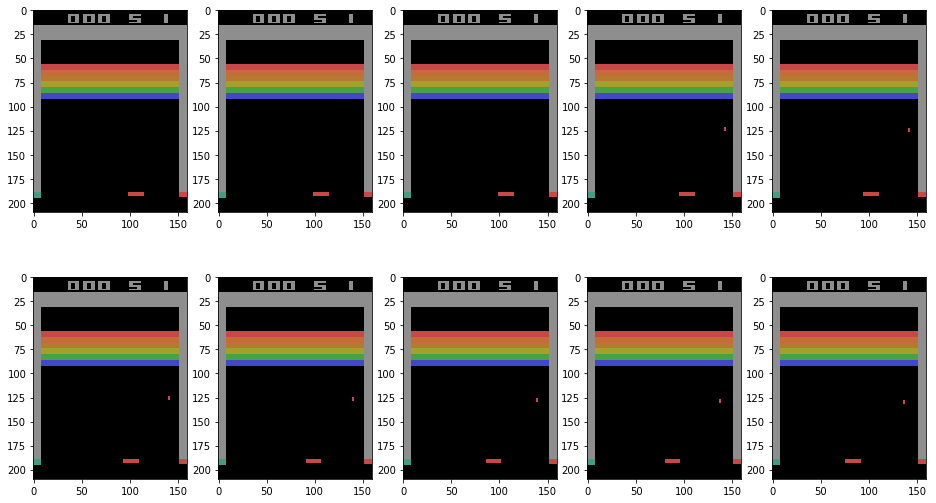

In [7]:
env = gym.make(atari_env_name)
env.reset()
env.seed(seed)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

**Here you can play the game.**

To launch it you should intall pygame package. This can work:

python -m pip install -U pygame --user

Anyway it can be a good idea to create a virtual environment in python for the case if something goes wrong.

Pay attention to zoom and fps args of play function.

In [8]:
# from gym.utils.play import play

# print('default control:\n',
#       gym.make(atari_env_name).unwrapped.get_keys_to_action()
#      )

# # here you can change the default control
# control = {
#     (): 0,
#     (ord(' '),): 1,
#     (ord('d'),): 2,
#     (ord('a'),): 3
# }

# play(env = gym.make(atari_env_name), keys_to_action=control, zoom=5, fps=30)

### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

Also please add an extra channel-dimension to the observation.

Tip: You can implement your own grayscale converter and assing the red channel a huge weight. This dirty trick is not necessary but it will speed up learning.

In [9]:
from gym.core import ObservationWrapper
from gym.spaces import Box

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        # your code here
        pass

    
    def _observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        #  * add channel dimension

        <Your code here >
        return < ... >

/home/zshrav/miniconda3/envs/myclone/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: <class '__main__.PreprocessAtariObs'> doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method.
Formal tests seem fine. Here's an example of what you'll get.


/home/zshrav/miniconda3/envs/myclone/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


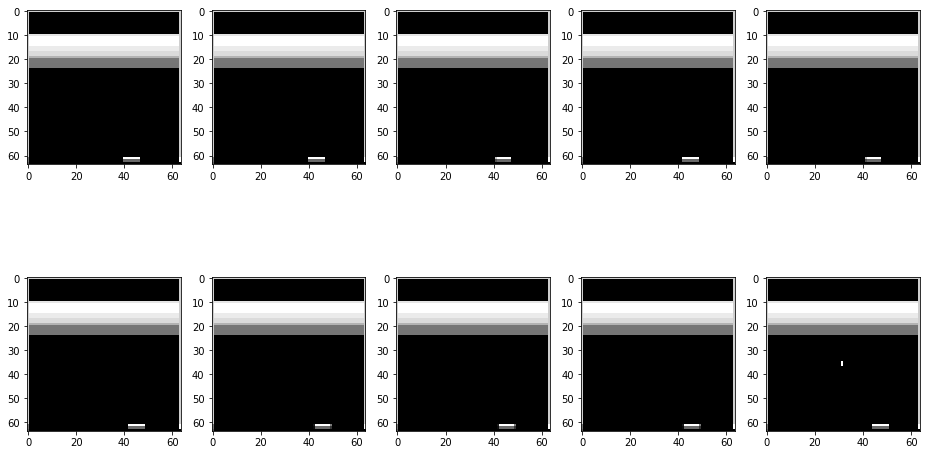

In [10]:
import gym
# spawn game instance for tests
env = gym.make(atari_env_name)  # create raw env
env = PreprocessAtariObs(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

env.reset()
obs, _, _, _ = env.step(env.action_space.sample())


# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
#         ax.imshow(env.render('rgb_array'))
plt.show()

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

**Here we apply some wrappers to the env.**

In [11]:
import atari_wrappers

def PrimaryAtariWrap(env, epidosic_life=True, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id
#     # This wrapper forces the env to make some random number
#     # of no-operation actions as an episode starts
#     env = atari_wrappers.NoopResetEnv(env, noop_max=30)

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should help your agent understand that losing is bad sonner.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can do it but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)
    
    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    env = atari_wrappers.ClipRewardEnv(env)
    
    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

**Let's see if the game is still playable after applying the wrappers.**

Pay attention to zoom and fps args of play function.
At playing the EpisodicLifeEnv wrapper seems not to work but actually it does. Have a look at its implementaion.

In [12]:
# from gym.utils.play import play

# # in torch imgs have shape [c, h, w] instead of common [h, w, c]
# class AntiTorchWrapper(ObservationWrapper):
#     def __init__(self, env):
#         ObservationWrapper.__init__(self, env)

#         self.img_size = [env.observation_space.shape[i]
#                            for i in [1, 2, 0]
#                         ]
#         self.observation_space = Box(0.0, 1.0, self.img_size)

#     def _observation(self, img):
#         """what happens to each observation"""
#         img = img.transpose(1, 2, 0)
#         return img

# def make_play_env():
#     env = gym.make(atari_env_name)
#     env = PrimaryAtariWrap(env)
#     env = AntiTorchWrapper(env)
#     return env

# print('default control:\n',
#       gym.make(atari_env_name).unwrapped.get_keys_to_action()
#      )

# # here you can change the default control
# control = {
#     (): 0,
#     (ord(' '),): 1,
#     (ord('d'),): 2,
#     (ord('a'),): 3
# }

# play(make_play_env(), keys_to_action=control, zoom=10, fps=3)

### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you, not really by the staff of the course :)

In [13]:
from framebuffer import FrameBuffer

def MakeAtari(episodic_life=True, clip_rewards=True, seed=None):
    env = gym.make(atari_env_name)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, episodic_life, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = MakeAtari()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


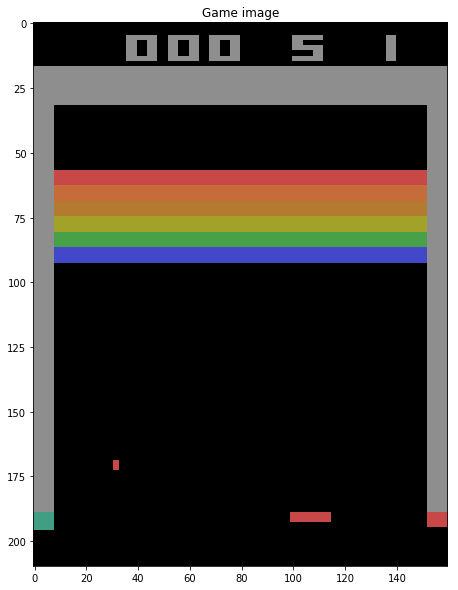

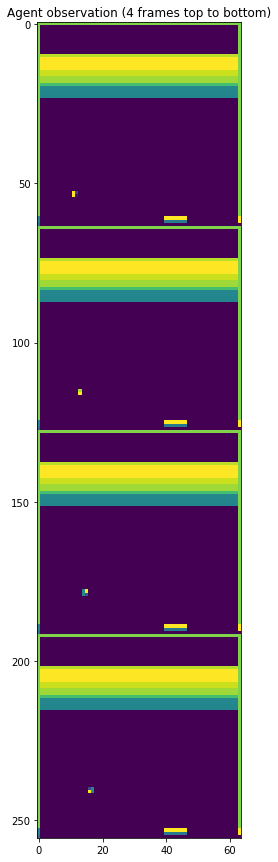

In [14]:
for _ in range(10):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_dim[2]]))
plt.show()

In [15]:
# you will need it to validate your implenetation of DQN
def MakeSimpleEnv(seed=None):
    env = gym.make('CartPole-v1')
    if seed is not None:
        env.seed(seed)
    return env


def MakeEnv(env_type, seed=None, **kwargs):
    if env_type == 'Atari':
        return MakeAtari(**kwargs, seed=seed)
    elif env_type == 'Simple':
        return MakeSimpleEnv(**kwargs, seed=seed)
    assert False

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png)

In [16]:
import torch
import torch.nn as nn
# this pattern can be useful when you want be able to launch your code
# noth on CPU and GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# device = 'cuda'

In [18]:
# this one is implemented
class SimpleQNet(nn.Sequential):
    """
    takes agent's observation - tensor of shape [batch_size, state_shape]
    returns qvalues - tensor of shape [batch_size, n_actions]

    """
    def __init__(self, state_shape, n_actions):
        super().__init__()
        state_dim = state_shape[0]
        self.add_module(
            'main',
            nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, n_actions)
            )
        )


# you don't have to use this function but it can be useful
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case is to define the size of the dense layer
    after convolutions:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

# Sequential architecture is quiet ok, but
# feel free to modify it any way you want
class ConvQNet(nn.Sequential):
    def __init__(self, state_shape, n_actions):
        """
        takes agent's observation - tensor of shape [batch_size, 4, h, w] (4 is n_frames)
        returns qvalues - tensor of shape [batch_size, n_actions]
        
        """
        super().__init__()
        self.n_actions = n_actions
        img_c, img_w, img_h = state_shape
        # Define your network body here. Please make sure agent is fully contained here
        cur_layer_img_w, cur_layer_img_h = img_w, img_h

        <YOUR CODE >


In [19]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, Network=ConvQNet, epsilon=0):
        """
        Network stands for a neural network constructor or class
        """
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.Network = Network

        self.net = Network(state_shape, n_actions)

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        Hint: if you're running on GPU, use state_t.cuda() right here.
        """

        # Use your network to compute qvalues for given state
        qvalues = <YOUR CODE >

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [20]:
env = MakeEnv('Atari')
n_actions = env.action_space.n
state_dim = env.observation_space.shape
agent = DQNAgent(state_dim, n_actions, ConvQNet, epsilon=0.5).to(device)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Now let's try out our agent to see if it raises any errors.

In [21]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [22]:
evaluate(env, agent, n_games=1)

0.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here __to get 2 bonus points__.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [23]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [24]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and final state
    """

    <YOUR CODE >

    return sum_rewards, s

In [25]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (
        10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [
        0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"

print("Well done!")

Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)



In [26]:
# This is how you can load weights from agent into target network
target_network = DQNAgent(agent.state_shape, agent.n_actions, agent.Network, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [27]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, c, h, w] for atari
                                                                       # or [batch_size, state_shape] in general 
    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, c, h, w]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values = < YOUR CODE >

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = <YOUR CODE >

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [28]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, gamma=0.99,
                       check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

Numerical tests:

In [30]:
agent = DQNAgent(state_dim, n_actions, ConvQNet, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, ConvQNet, epsilon=1).to(device)
# to call zero_grad()
opt = torch.optim.Adam(agent.parameters())
for test_name in sorted(os.listdir('TestSamples')):
    print('test case', test_name)
    dir_name = os.path.join('TestSamples', test_name)
    agent.load_state_dict(torch.load(os.path.join(dir_name, 'agent')))
    target_network.load_state_dict(torch.load(os.path.join(dir_name, 'target_network')))
    obs_batch = torch.load(os.path.join(dir_name, 'obs'))
    act_batch = torch.load(os.path.join(dir_name, 'act'))
    reward_batch = torch.load(os.path.join(dir_name, 'reward'))
    next_obs_batch = torch.load(os.path.join(dir_name, 'next_obs'))
    is_done_batch = torch.load(os.path.join(dir_name, 'is_done'))
    
    ref_loss = torch.load(os.path.join(dir_name, 'loss'))
    ref_grads = torch.load(os.path.join(dir_name, 'grads'))
    
    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, gamma=0.99,
                           check_shapes=False)
    loss.backward()
    grads = [param.grad.data.cpu().numpy() for param in agent.parameters()]
    opt.zero_grad()

    assert np.allclose(loss.cpu().item(), ref_loss)
    for grad, ref_grad in zip(grads, ref_grads):
        assert np.allclose(grad, ref_grad)
    print('\tpassed')
print('All tests passed!')

test case 0
	passed
test case 1
	passed
test case 2
	passed
test case 3
	passed
test case 4
	passed
test case 5
	passed
test case 6
	passed
test case 7
	passed
test case 8
	passed
test case 9
	passed
All tests passed!


### Main loop

It's time to put everything together and see if it learns anything.

In [31]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

This can save your laptop from freezing

In [32]:
import psutil
mem = psutil.virtual_memory()
mem.available / (1024 * 1024 * 1024)

def IsEnoughRam(min_available_gb = 0.1):
    mem = psutil.virtual_memory()
    return mem.available >= min_available_gb * (1024 ** 3)

def LinearDecay(init_val, final_val, cur_step, total_steps):
    if cur_step >= total_steps:
        return final_val
    return (init_val * (total_steps - cur_step) + final_val * cur_step) / total_steps

In [33]:
seed = 2
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## first choose Simple env_type and finish the task with it!

In [34]:
env_type = 'Simple'
# env_type = 'Atari'
env = MakeEnv(env_type, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

if env_type == 'Simple':
    Network = SimpleQNet
elif env_type == 'Atari':
    Network = ConvQNet

agent = DQNAgent(state_dim, n_actions, Network, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, Network, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

/home/zshrav/miniconda3/envs/myclone/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning a little, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [35]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not IsEnoughRam():
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
print(len(exp_replay))

10000.0
10000


**So, now hyperparameters.**

Finding good values can really hurt. Here are some values that will probably lead to good performance. You can tune them if you want but it will take a lot of effort. See the later discussion under "how to interpret plots". When launching on Atari surely you will have enough time to read it.

In [36]:
if env_type == 'Atari':
    batch_size = 32
    total_steps = 3 * 10**6
    decay_steps = 10**6

    opt = torch.optim.Adam(agent.parameters(), lr=1e-4)
    init_epsilon = 1
    final_epsilon = 0.1

    loss_freq = 50
    refresh_target_network_freq = 5000
    output_freq = 5000

    max_grad_norm = 50
    
    eval_env_kwargs = {
        'clip_rewards': False,
        'episodic_life': False
    }

if env_type == 'Simple':
    batch_size = 32
    total_steps = 3 * 10**4
    decay_steps = 10**4

    opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

    init_epsilon = 1
    final_epsilon = 0.1

    loss_freq = 20
    refresh_target_network_freq = 500
    output_freq = 100
    
    max_grad_norm = 50
    
    eval_env_kwargs = {}

In [37]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 10000, epsilon = 0.10000
opt state: <bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)>


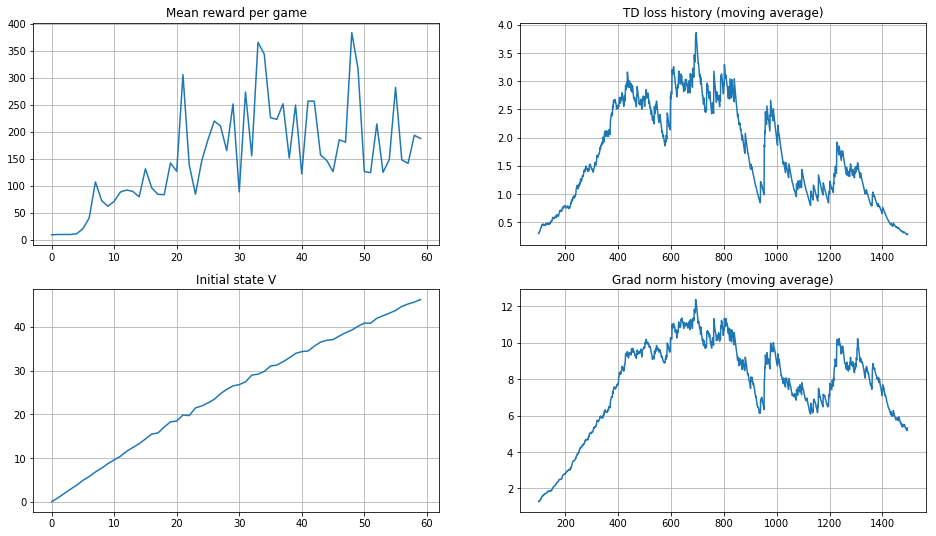

100%|██████████| 30000/30000 [04:19<00:00, 115.72it/s]


In [38]:
state = env.reset()
for step in trange(total_steps):
    if not IsEnoughRam():
        print('Less that 100 Mb RAM available, waiting...')
        print('Make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = LinearDecay(init_epsilon, final_epsilon, step, decay_steps)
        
    # play
    _, state = play_and_record(state, agent, env, exp_replay, 1)

    # train
    < sample data from experience replay >

    loss = < compute TD loss >

    < minimize loss by gradient descent >

    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    # adjust agent parameters
    if step % refresh_target_network_freq == 0:
        mean_rw_history.append(evaluate(
            MakeEnv(env_type, seed=step, **eval_env_kwargs), agent, n_games=3, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues([MakeEnv(env_type, seed=step).reset()])
        initial_state_v_history.append(np.max(initial_state_q_values))
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % output_freq == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))
        print('opt state:', opt.state_dict)
        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(
            np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()
        
        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (moving average)")
        plt.plot(moving_average(
            np.array(grad_norm_history), span=100, min_periods=100))
        plt.grid()
        
        plt.show()

In [39]:
if env_type == 'Simple':
    assert np.mean(mean_rw_history[-10:]) > 100.
    print("That's good enough for tutorial.")
if env_type == 'Atari':
    assert np.mean(mean_rw_history[-10:]) > 10.
    print("That's good enough for tutorial.")

That's good enough for tutorial.


**How to interpret plots:**

Simple env should finish training with good performance in 30 minutes on CPU and in 5 minutes on GPU. You can see from here how the plots can behave.

**About Atari**

This aint no supervised learning so don't expect anything to improve monotonously. 
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50).
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 5-10k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agaent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Also please ignore first 100-200 steps of each plot - they're just oscillations because of the way moving average works.

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's gonna start winning (average reward > 10) after 20k steps. 

But hey, long training time isn't _that_ bad:
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)


## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (because of lack of exploration) [note that not all the states are visited often enough to influence the loss function optimized in terms of MSE]

* Total timesteps and training time: It seems to be so huge, but actually it normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and often it works not worse than Adam. For us Adam was default and it worked.

* lr: $10^3$ would probably be too huge

* batch size: if it is too small the agent can fail to learn. Huge batch takes more time to process

* target network update frequency: too frequent updates can lead to divergence. Too rare can lead to slow leraning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an interation of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.
* max_grad_norm - just huge enough. In torch clip_grad_norm also evaluates the norm before clipping and it can be convenient for logging.

### Video

In [40]:
# record sessions
import gym.wrappers
seed = 5
env_monitor = gym.wrappers.Monitor(MakeEnv(env_type, seed=seed, **eval_env_kwargs), directory="videos", force=True)
sessions = [evaluate(env_monitor, agent, n_games=1, greedy=True) for _ in range(10)]
env_monitor.close()

In [41]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

## Main Assignment (10 pts)

1) Preprocess atari images and implement DQNAgent for Atari (1+1 pts)

2) Implement compute_td_loss (3 pts)

3) Train Simple env and beat threashold (3 pts)

4) Train Atari env and beat threshold (2 pts). Feel free to use any extention of basic Q-learning here (see bonus tasks) including the ones taken from open source (e.g. prioritized experience replay)

If 4) is done, 3) is considered done automatically.

It is ok to send 2 notebooks (one with Simple and one with Atari) or as many as necessary

## Bonus I (2+ pts)

Implement and train double q-learning.

This task contains of
* Implementing __double q-learning__ or __dueling q-learning__ or both (see tips below)
* Training a network till convergence
  * Full points will be awarded if your network gets average score of >=10 (see "evaluating results")
  * Higher score = more points as usual
  * If you're running out of time, it's okay to submit a solution that hasn't converged yet and updating it when it converges. _Lateness penalty will not increase for second submission_, so submitting first one in time gets you no penalty.


#### Tips:
* Implementing __double q-learning__ shouldn't be a problem if you've already have target networks in place.
  * You will probably need `tf.argmax` to select best actions
  * Here's an original [article](https://arxiv.org/abs/1509.06461)

* __Dueling__ architecture is also quite straightforward if you have standard DQN.
  * You will need to change network architecture, namely the q-values layer
  * It must now contain two heads: V(s) and A(s,a), both dense layers
  * You should then add them up via elemwise sum layer.
  * Here's an [article](https://arxiv.org/pdf/1511.06581.pdf)

## Bonus II (5+ pts): Prioritized experience replay

In this section, you're invited to implement prioritized experience replay

* You will probably need to provide a custom data structure
* Once pool.update is called, collect the pool.experience_replay.observations, actions, rewards and is_alive and store them in your data structure
* You can now sample such transitions in proportion to the error (see [article](https://arxiv.org/abs/1511.05952)) for training.

It's probably more convenient to explicitly declare inputs for "sample observations", "sample actions" and so on to plug them into q-learning.

Prioritized (and even normal) experience replay should greatly reduce amount of game sessions you need to play in order to achieve good performance. 

While it's effect on runtime is limited for atari, more complicated envs (further in the course) will certainly benefit for it.

Prioritized experience replay only supports off-policy algorithms, so pls enforce `n_steps=1` in your q-learning reference computation (default is 10).

## Bonus III (3+ pts): Speeding up

**Asynchronous training:**
Collecting experience and training from buffer can be done asynchronously thus much improving the speed of training.

**Any other methods:** Hyperparameters, network architecture, Wrappers(must not be too environment-specific)

## Bonus IV (3+ pts): Interpretation and Visualization

Try to interpret what the agent has learnt. See in which states the agent behaves better and in which he behaves worse. May be the agent understands that in some states it does not matter what action he will take? Find a way to visualise V, Q or Advantage function or anything else cool.

For such analysis you can choose any environment. Some env with 1-dimentional state would be a good variant - look them up at gym website.

The deeper the analysis and the cooler is the visualisation the more pts you obtain.

10 pts is not the limit :)

## Bonus IV (? pts): Anything cool :)

Want to do something? Just do it and get your points!